In [94]:
%reset -f

In [95]:
%pip install seaborn
%pip install scipy
%pip install pyshp
%pip install geopandas
%pip install shapely
%pip install plotly
%pip install plotly-geo
%pip install nbformat 

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [96]:
import pandas as pd
import gc
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import scipy as sp


In [97]:
import geopandas
import shapely
import plotly
import plotly.figure_factory as ff
import nbformat
import plotly.express as px
import plotly.graph_objects as go

In [98]:
places = pd.read_csv('PLACES.csv')
dentist=pd.read_csv('DENTIST.csv')
fips=pd.read_csv('FIPS.csv')
popclass=pd.read_csv('POPCLASS.csv')
pd.set_option('display.max_columns', None)

In [99]:
places=places.loc[places['Short_Question_Text'].isin(['Dental Visit','Mental Health','Annual Checkup','General Health','Health Insurance'])]
places = places.drop(places[places['StateDesc'] == 'United States'].index)
places.drop(columns=['StateAbbr','Category','DataSource','Data_Value_Footnote_Symbol','Data_Value_Footnote','DataValueTypeID','Counties','States','MeasureId','Low_Confidence_Limit','High_Confidence_Limit','StateDesc','LocationName'], inplace=True)
places=places.rename({'LocationID':'FULLFIPS'}, axis=1)
places["FULLFIPS"] = places["FULLFIPS"].astype("string").str.zfill(5)
places['Geolocation'] = places['Geolocation'].str.replace('POINT ', '')
places['Geolocation'] = places['Geolocation'].astype(str).str.replace(r"\(|\)", "", regex=True)
places[['long', 'lat']] = places['Geolocation'].str.split(' ', expand=True)


In [92]:
places

,Year,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,TotalPopulation,FULLFIPS,CategoryID,Short_Question_Text,Geolocation,long,lat
365,2021,Fair or poor self-rated health status among ad...,%,Age-adjusted prevalence,21.2,64629,35005,HLTHSTAT,General Health,-104.4698374 33.3616045,-104.4698374,33.3616045
370,2021,Current lack of health insurance among adults ...,%,Age-adjusted prevalence,8.8,44021,17177,PREVENT,Health Insurance,-89.6659942 42.3497262,-89.6659942,42.3497262
392,2020,Visits to dentist or dental clinic among adult...,%,Crude prevalence,65.5,849316,24005,PREVENT,Dental Visit,-76.6165693 39.4431666,-76.6165693,39.4431666
395,2021,Mental health not good for >=14 days among adu...,%,Crude prevalence,17.9,70164,41035,HLTHSTAT,Mental Health,-121.6461682 42.6837613,-121.6461682,42.6837613
402,2021,Current lack of health insurance among adults ...,%,Crude prevalence,5.5,164759,09007,PREVENT,Health Insurance,-72.5227802 41.4330028,-72.5227802,41.4330028
...,...,...,...,...,...,...,...,...,...,...,...,...
228712,2020,Visits to dentist or dental clinic among adult...,%,Crude prevalence,70.3,20543,55061,PREVENT,Dental Visit,-87.4480081 44.6056771,-87.4480081,44.6056771
228721,2021,Fair or poor self-rated health status among ad...,%,Crude prevalence,22.3,5863,48169,HLTHSTAT,General Health,-101.3011341 33.183792,-101.3011341,33.183792
228748,2021,Fair or poor self-rated health status among ad...,%,Crude prevalence,18.2,58370,54037,HLTHSTAT,General Health,-77.86322 39.3073985,-77.86322,39.3073985
228752,2021,Visits to doctor for routine checkup within th...,%,Age-adjusted prevalence,69.8,867947,48141,PREVENT,Annual Checkup,-106.2414234 31.7664803,-106.2414234,31.7664803


In [100]:
fips=fips.rename({'FIPS State':'STATEFP', 'FIPS County':'COUNTYFP'}, axis=1)

fips["STATEFP"] = fips["STATEFP"].astype("string").str.zfill(2)
fips["COUNTYFP"] = fips["COUNTYFP"].astype("string").str.zfill(3)
fips['FULLFIPS'] = fips['STATEFP'].astype(str) + fips['COUNTYFP']

In [101]:
placesfips=pd.merge(places, fips, how="outer", on=['FULLFIPS'])
placesfips=placesfips.dropna() 

In [102]:
dentist.drop(columns=['popn_densty_per_squr_mi_10','popn_densty_per_squr_mi_20','fips_st_cnty','secndry_entity_file','st_name_abbrev','popn_21','st_name','cnty_name'], inplace=True)
dentist=dentist.rename({'fips_st':'STATEFP', 'fips_cnty':'COUNTYFP'}, axis=1)
dentist["STATEFP"] = dentist["STATEFP"].astype("string").str.zfill(2)
dentist["COUNTYFP"] = dentist["COUNTYFP"].astype("string").str.zfill(3)
dentist['FULLFIPS'] = dentist['STATEFP'].astype(str) + dentist['COUNTYFP']
dentist=dentist.drop(['STATEFP','COUNTYFP'], axis=1)
dentist=dentist.dropna() 

In [103]:
dentpl1=pd.merge(placesfips, dentist, how="outer", on=['FULLFIPS'])
dentpl1=dentpl1.dropna() 


In [104]:
popclass=popclass.rename({"FIPS code":"FULLFIPS", "2013 code":"pop_code"}, axis=1)
popclass['pop_code'] = popclass['pop_code'].astype(float)
popclass["FULLFIPS"] = popclass["FULLFIPS"].astype("string").str.zfill(5)



In [105]:
dentpl=pd.merge(dentpl1, popclass, how="outer", on=['FULLFIPS'])
dentpl['pop_code'] = dentpl['pop_code'].astype('Int32')

In [106]:
dentpl[dentpl.select_dtypes(np.float64).columns] = dentpl.select_dtypes(np.float64).astype(np.float32)
dentpl[['dent_ratio']] = dentpl[['dent_npi_21']].div(dentpl.TotalPopulation, axis=0)
dentpl[['dent_per_1000']]=dentpl[['dent_ratio']].multiply(1000)
dentpl[['Data_Value_Num']] = dentpl[['Data_Value']].div(100)
dentpl[['val_per_1000']]=dentpl[['Data_Value_Num']].multiply(1000)
dentpl[['total_num']] = dentpl[['Data_Value_Num']].multiply(dentpl.TotalPopulation, axis=0)
dentpl = dentpl.dropna() 


In [107]:
dentpl_crude = dentpl.drop(dentpl[dentpl['Data_Value_Type'] == 'Age-adjusted prevalence'].index)
dentpl_crude.drop(columns=['Data_Value_Type','STATEFP','COUNTYFP'], inplace=True)
dentpl_crude=dentpl_crude.rename({'Year':'year','Measure':'measure','Data_Value_Unit':'data_value_unit','Data_Value':'data_value','TotalPopulation':'total_pop','FULLFIPS':'fips','CategoryID':'category_id','Short_Question_Text':'category','State':'state','County Name':'county','dent_npi_21':'num_dentists'}, axis=1)
dentpl_crude = dentpl_crude[['fips','state','county','total_pop','pop_code','category','measure', 'category_id','data_value','data_value_unit','val_per_1000','num_dentists','dent_per_1000','year','lat','long','Geolocation']]



In [108]:
def cond(dentpl_crude):    
    if (dentpl_crude['pop_code'] == 1) or (dentpl_crude['pop_code'] == 2):
        return 'urban'
    elif (dentpl_crude['pop_code'] == 3) or (dentpl_crude['pop_code'] == 4):
        return 'suburban'
    elif (dentpl_crude['pop_code'] == 5) or (dentpl_crude['pop_code'] == 6):
        return 'rural'

dentpl_crude['pop_type'] = dentpl_crude.apply(cond, axis = 1)

In [109]:
dentpl_crude_pivot = dentpl_crude.pivot_table('val_per_1000', ['fips','num_dentists','dent_per_1000','total_pop','pop_code','pop_type','lat','long','Geolocation','state','county'], 'category').reset_index().rename_axis('index',axis=1) 
dentpl_crude_pivot[dentpl_crude_pivot.select_dtypes(np.float64).columns] = dentpl_crude_pivot.select_dtypes(np.float64).astype(np.float32)
dentpl_crude_pivot.head()

index,fips,num_dentists,dent_per_1000,total_pop,pop_code,pop_type,lat,long,Geolocation,state,county,Annual Checkup,Dental Visit,General Health,Health Insurance,Mental Health
0,01001,19.0,0.321516,59095.0,3,suburban,32.5322367,-86.6464395,-86.6464395 32.5322367,Alabama,Autauga,775.0,632.000000,184.000000,100.000000,171.000000
1,01003,114.0,0.476401,239294.0,4,suburban,30.6592183,-87.7460666,-87.7460666 30.6592183,Alabama,Baldwin,759.0,663.000061,170.000000,88.999992,157.000000
2,01005,8.0,0.320461,24964.0,6,rural,31.8702531,-85.4051035,-85.4051035 31.8702531,Alabama,Barbour,786.0,482.000000,291.000000,167.000015,192.999985
3,01007,6.0,0.266940,22477.0,2,urban,33.0158929,-87.1271475,-87.1271475 33.0158929,Alabama,Bibb,741.0,537.000000,232.000015,140.000000,187.000000
4,01009,10.0,0.169374,59041.0,2,urban,33.9773575,-86.56644,-86.56644 33.9773575,Alabama,Blount,752.0,590.000000,202.000000,125.000000,176.000000


In [110]:
chattahoochee = dentpl_crude_pivot[(dentpl_crude_pivot['dent_per_1000']<8.5) & (dentpl_crude_pivot['dent_per_1000']>7.9)]
chattahoochee


index,fips,num_dentists,dent_per_1000,total_pop,pop_code,pop_type,lat,long,Geolocation,state,county,Annual Checkup,Dental Visit,General Health,Health Insurance,Mental Health
404,13053,74.0,8.178603,9048.0,3,suburban,32.3474454,-84.7880206,-84.7880206 32.3474454,Georgia,Chattahoochee,695.0,524.0,154.0,207.0,198.0


In [111]:
dentpl_crude_pivot=dentpl_crude_pivot.drop(dentpl_crude_pivot[dentpl_crude_pivot['fips'] == '13053'].index)
#removing chattahoochee for being weirdly overrun with dentists
dentpl_crude_pivot = dentpl_crude_pivot.dropna() 
#dropping NaNs drops all of florida because there is no data on them in the original dataset
dentpl_crude_pivot.head()

index,fips,num_dentists,dent_per_1000,total_pop,pop_code,pop_type,lat,long,Geolocation,state,county,Annual Checkup,Dental Visit,General Health,Health Insurance,Mental Health
0,01001,19.0,0.321516,59095.0,3,suburban,32.5322367,-86.6464395,-86.6464395 32.5322367,Alabama,Autauga,775.0,632.000000,184.000000,100.000000,171.000000
1,01003,114.0,0.476401,239294.0,4,suburban,30.6592183,-87.7460666,-87.7460666 30.6592183,Alabama,Baldwin,759.0,663.000061,170.000000,88.999992,157.000000
2,01005,8.0,0.320461,24964.0,6,rural,31.8702531,-85.4051035,-85.4051035 31.8702531,Alabama,Barbour,786.0,482.000000,291.000000,167.000015,192.999985
3,01007,6.0,0.266940,22477.0,2,urban,33.0158929,-87.1271475,-87.1271475 33.0158929,Alabama,Bibb,741.0,537.000000,232.000015,140.000000,187.000000
4,01009,10.0,0.169374,59041.0,2,urban,33.9773575,-86.56644,-86.56644 33.9773575,Alabama,Blount,752.0,590.000000,202.000000,125.000000,176.000000


In [112]:
nix_la=dentpl_crude_pivot.drop(dentpl_crude_pivot[dentpl_crude_pivot['fips'] == '06037'].index)
#removing LA for outlier reasons

In [113]:
nix_la[nix_la.isnull().any(axis=1)]

index,fips,num_dentists,dent_per_1000,total_pop,pop_code,pop_type,lat,long,Geolocation,state,county,Annual Checkup,Dental Visit,General Health,Health Insurance,Mental Health


In [114]:
dcp_corr=nix_la.drop(['fips','pop_code','pop_type','lat','long','Geolocation','state','county'], axis=1)

C:\Users\smirn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\smirn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\smirn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\smirn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\smirn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a

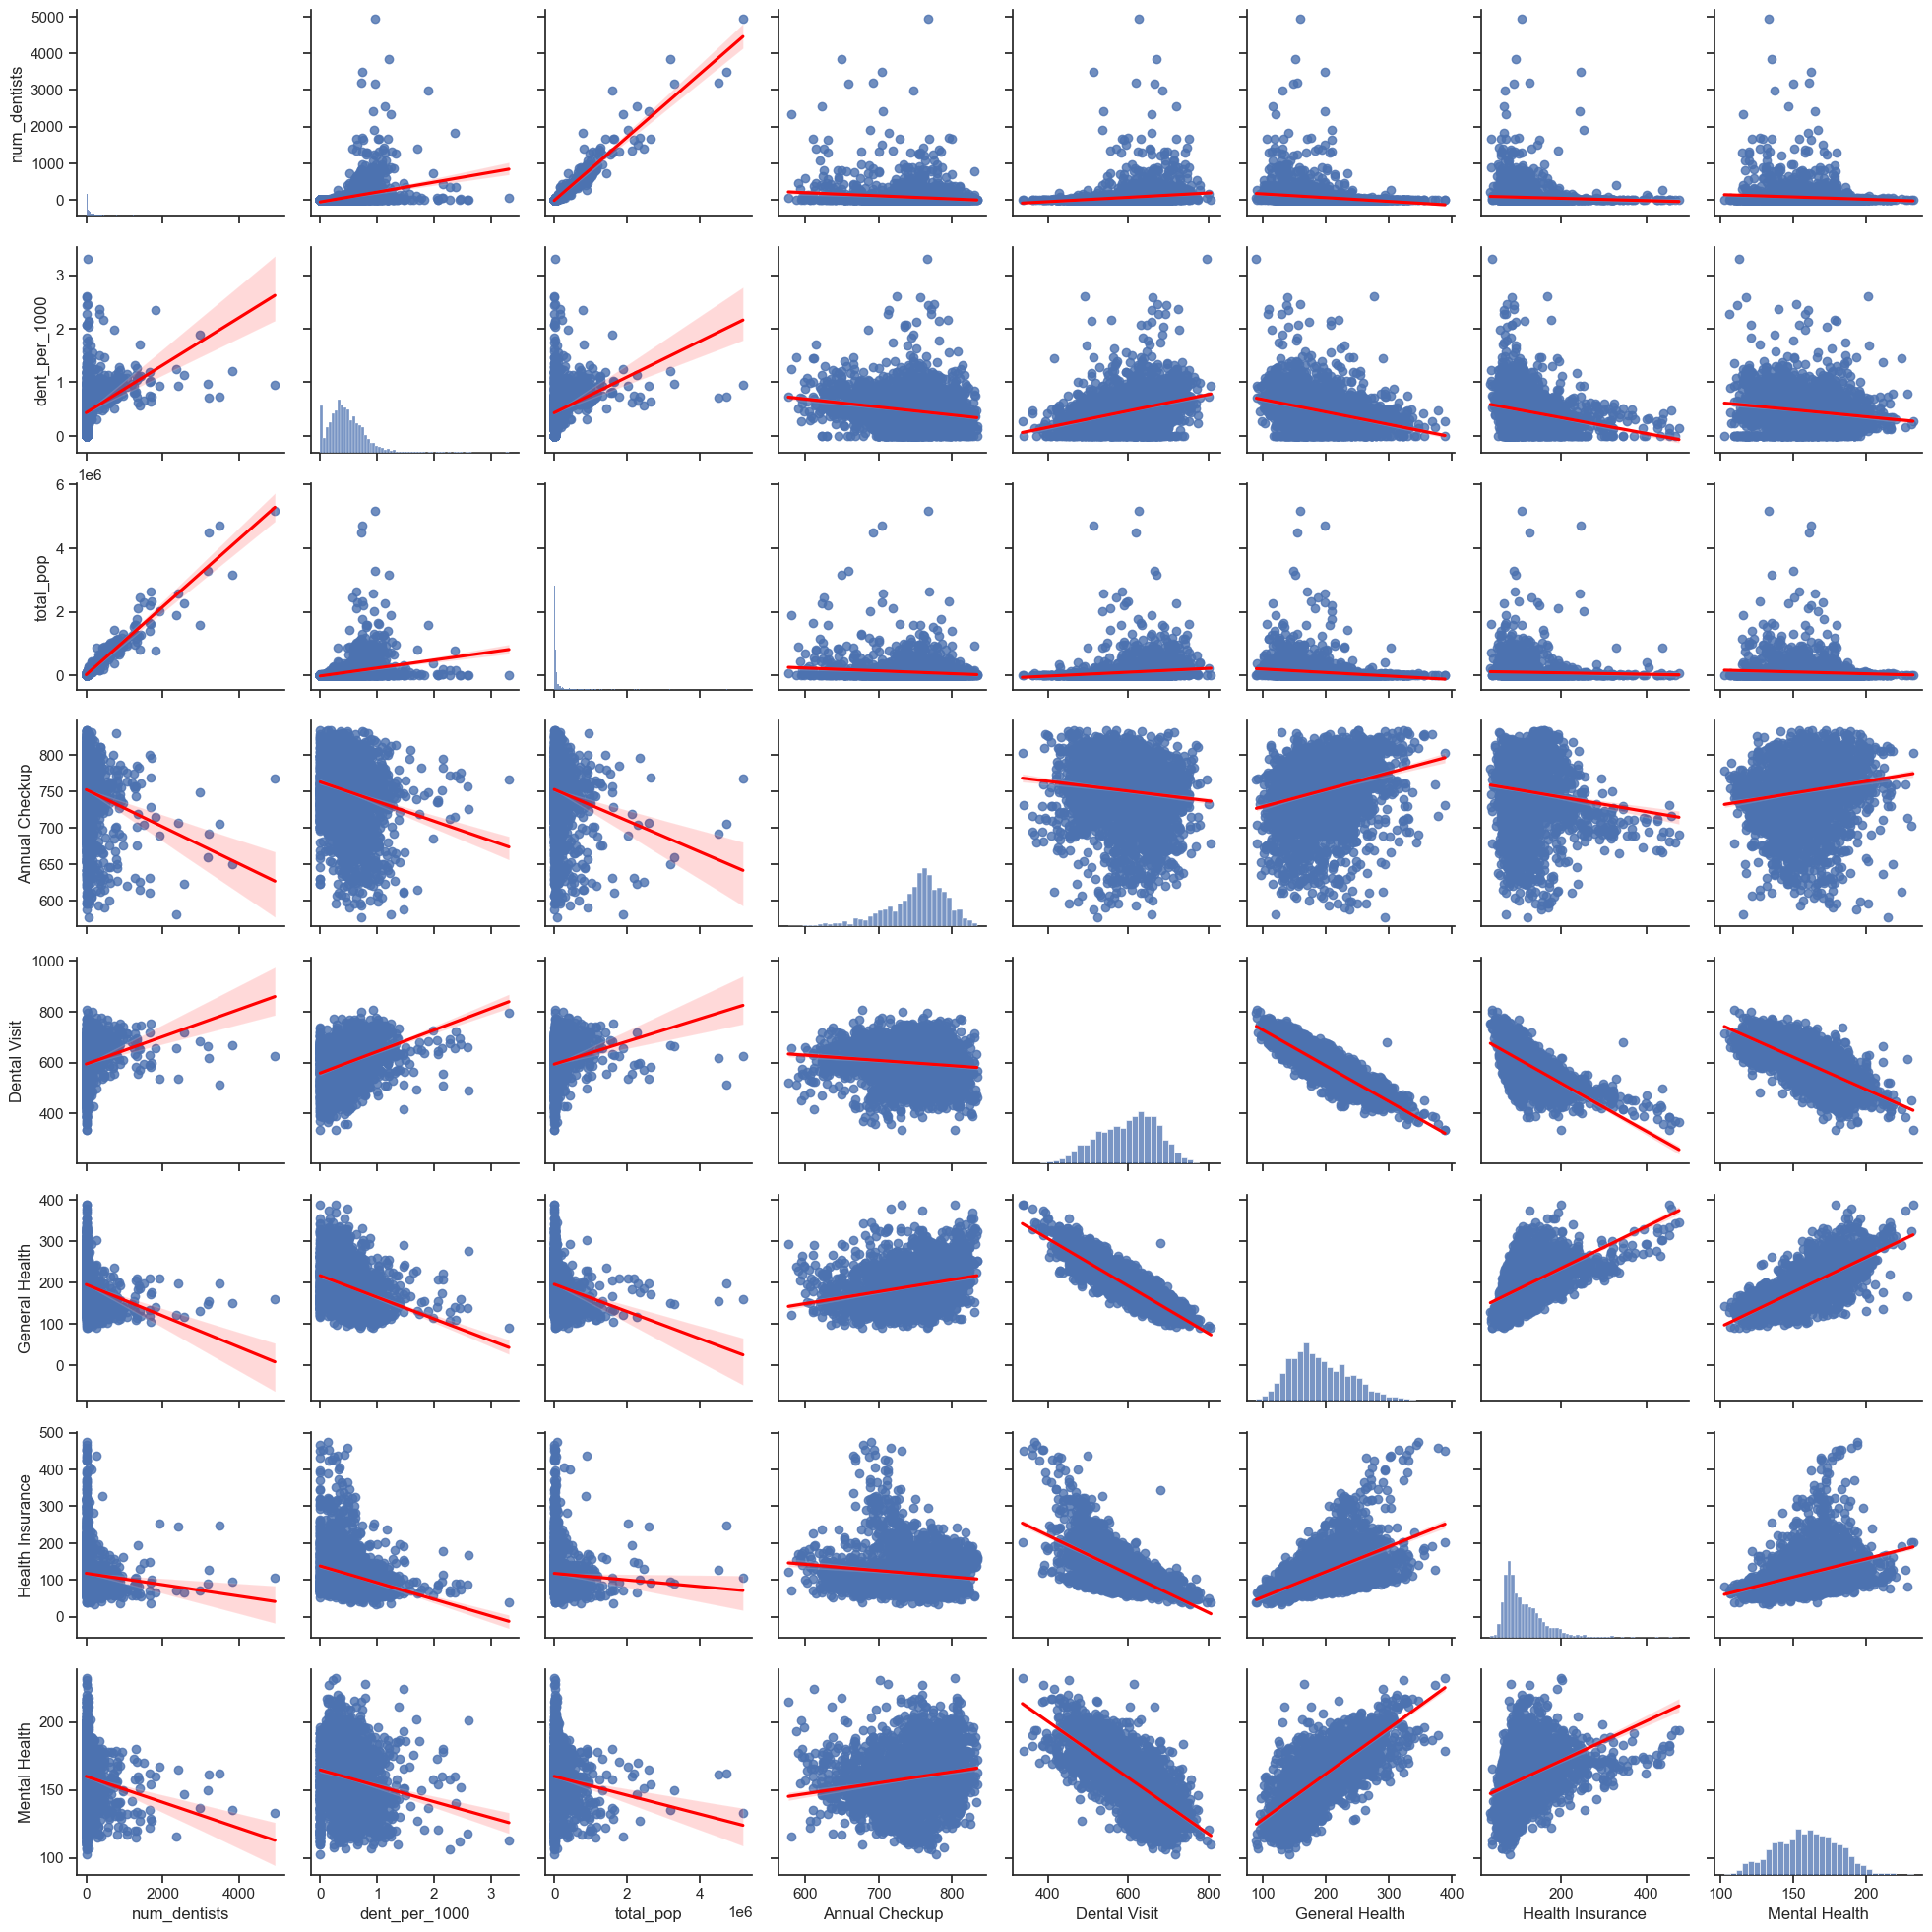

In [65]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(dcp_corr, kind='reg',plot_kws={'line_kws':{'color':'red'}})

In [66]:
dcp_corr.corr()

index,num_dentists,dent_per_1000,total_pop,Annual Checkup,Dental Visit,General Health,Health Insurance,Mental Health
index,,,,,,,,
num_dentists,1.000000,0.346095,0.959972,-0.147645,0.177924,-0.196745,-0.069224,-0.111177
dent_per_1000,0.346095,1.000000,0.290123,-0.200641,0.359756,-0.349529,-0.259799,-0.175287
total_pop,0.959972,0.290123,1.000000,-0.138541,0.164649,-0.190414,-0.044554,-0.090211
Annual Checkup,-0.147645,-0.200641,-0.138541,1.000000,-0.117530,0.259491,-0.130305,0.163257
Dental Visit,0.177924,0.359756,0.164649,-0.117530,1.000000,-0.895009,-0.703265,-0.725759
General Health,-0.196745,-0.349529,-0.190414,0.259491,-0.895009,1.000000,0.588233,0.752534
Health Insurance,-0.069224,-0.259799,-0.044554,-0.130305,-0.703265,0.588233,1.000000,0.382060
Mental Health,-0.111177,-0.175287,-0.090211,0.163257,-0.725759,0.752534,0.382060,1.000000


C:\Users\smirn\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



Text(0.5, 1.0, 'Relationships of Interest')

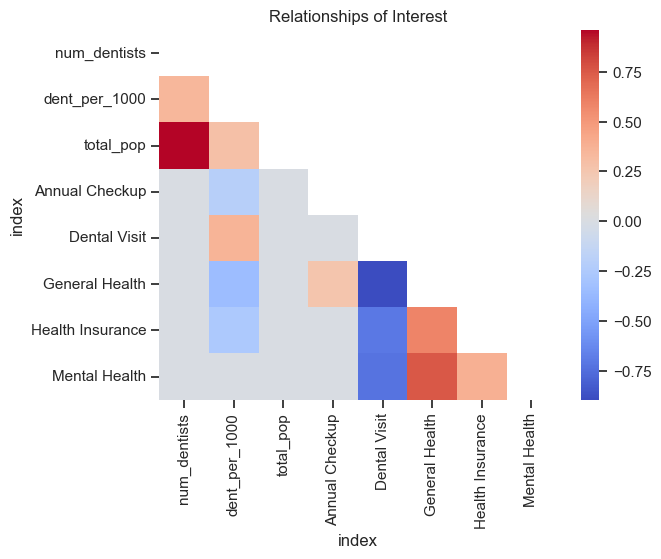

In [67]:
corr = dcp_corr.select_dtypes('number').corr()
corr[np.abs(corr)<.2] = 0

mask = np.triu(np.ones_like(corr.corr(), dtype=bool))

sns.heatmap(corr,mask=mask,cmap="coolwarm", annot=True).set_title('Relationships of Interest')

[Text(0.5, 1.0, 'Annual Checkups and Dental Visits by Area Type'),
 Text(0.5, 0, 'Population Type (1=Urban, 6=Rural)'),
 Text(0, 0.5, 'Value per 1000 people')]

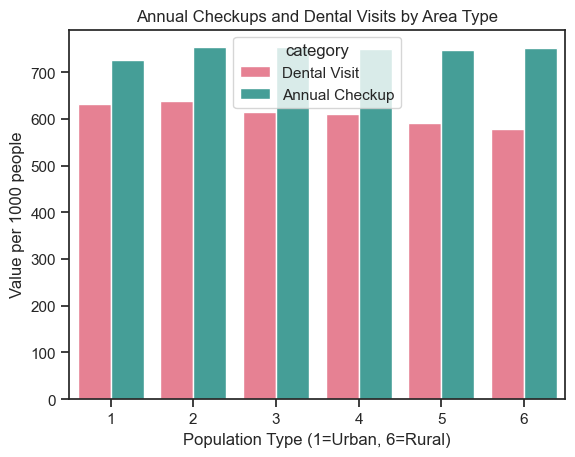

In [68]:
data=dentpl_crude.loc[dentpl_crude['category'].isin(['Dental Visit','Annual Checkup'])]
sns.barplot(data=data,x = 'pop_code', y = "val_per_1000",
            hue = "category", errorbar = None, palette='husl').set(title='Annual Checkups and Dental Visits by Area Type',xlabel='Population Type (1=Urban, 6=Rural)', ylabel='Value per 1000 people')


Text(0, 0.5, 'Total Population')

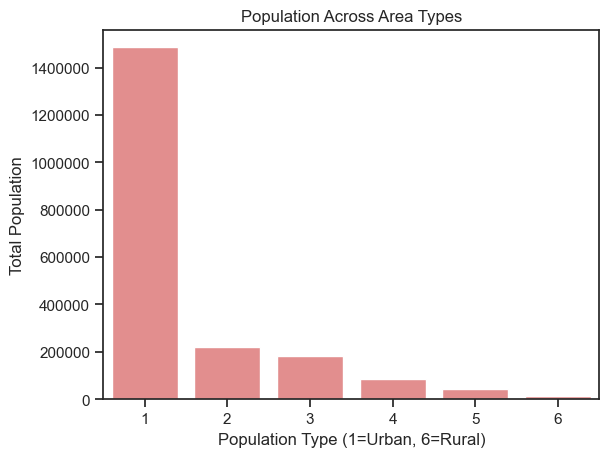

In [69]:
popsns=sns.barplot(x = 'pop_code',
            y = 'total_pop',
            data = dentpl_crude_pivot,
           errorbar = None,
           color='lightcoral')
plt.ticklabel_format(style='plain', axis='y')

popsns.set_title('Population Across Area Types')
popsns.set_xlabel('Population Type (1=Urban, 6=Rural)')
popsns.set_ylabel('Total Population')


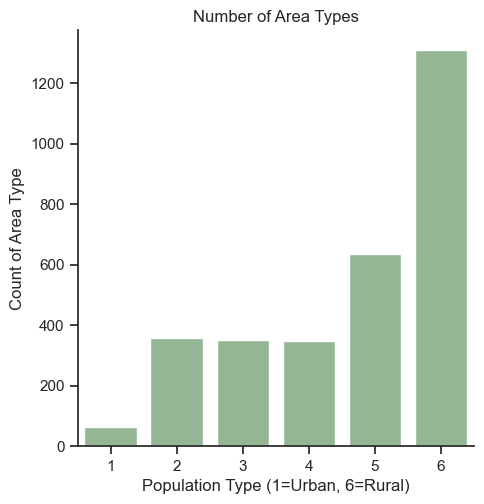

In [70]:
typesns=sns.catplot(data=dentpl_crude_pivot, kind='count', x='pop_code',color = "darkseagreen",
            saturation = 0.75).set(title='Number of Area Types',xlabel='Population Type (1=Urban, 6=Rural)', ylabel='Count of Area Type')


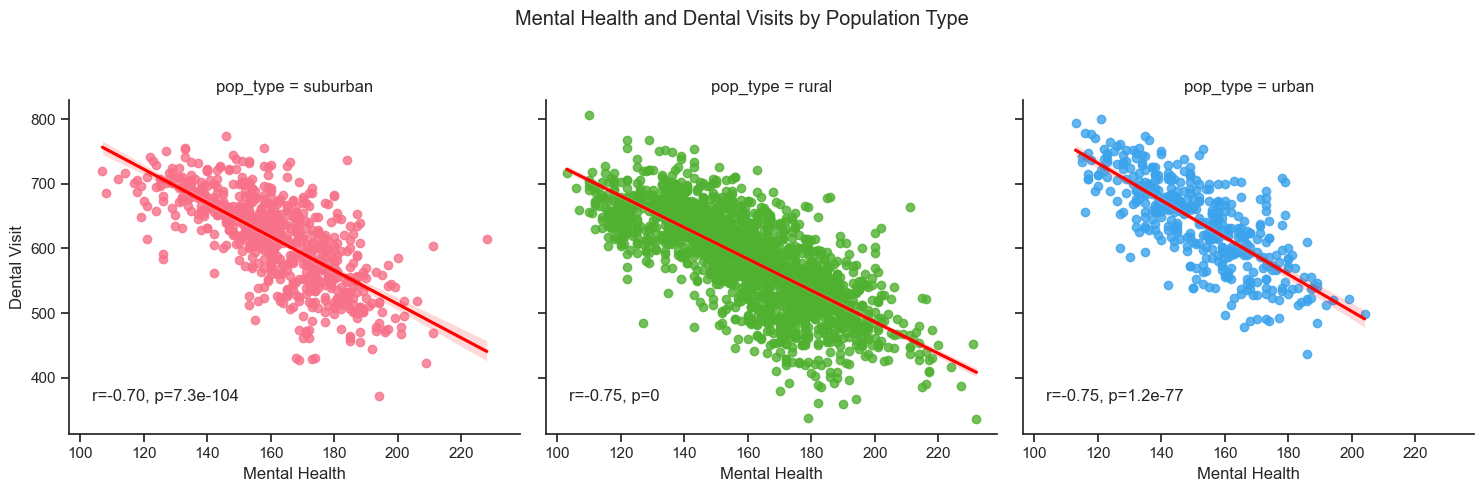

In [71]:
g=sns.lmplot(x = 'Mental Health', y = 'Dental Visit',
           col = "pop_type",hue = "pop_type",palette = "husl",
           line_kws = {"color": "red"},data = dentpl_crude_pivot)



def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Mental Health'], data['Dental Visit'])
    ax = plt.gca()
    ax.text(.05, .1, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

    
g.map_dataframe(annotate)
g.fig.subplots_adjust(top = 0.8)
g.fig.suptitle("Mental Health and Dental Visits by Population Type")
plt.show()

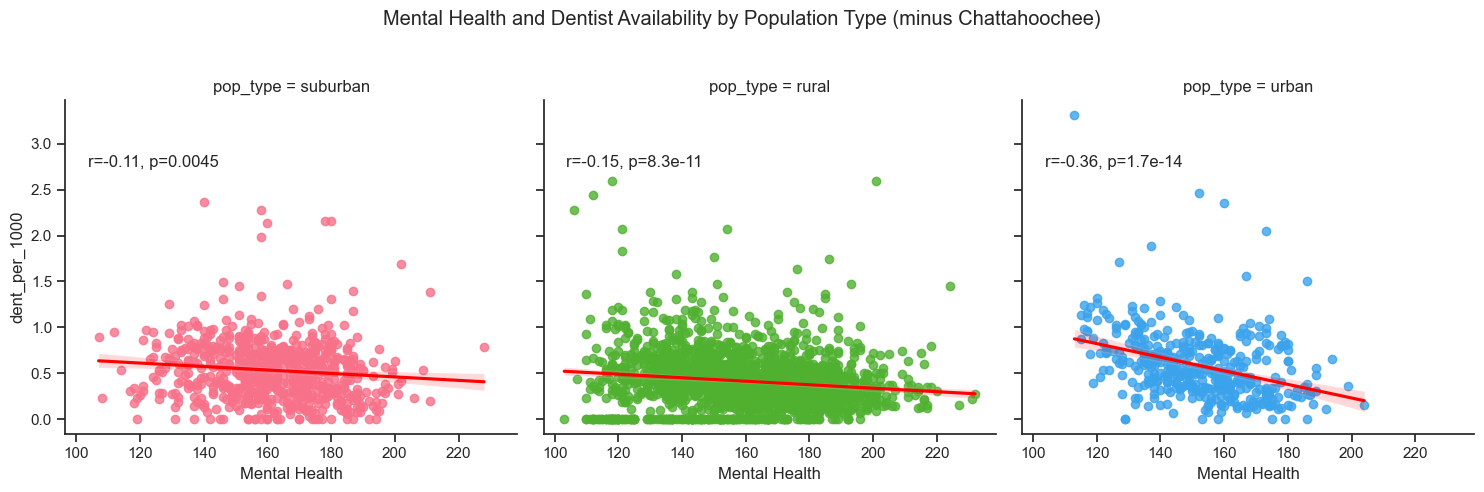

In [72]:
h=sns.lmplot(x = 'Mental Health', y = 'dent_per_1000',
           col = "pop_type",hue = "pop_type",palette = "husl",
           line_kws = {"color": "red"},data = dentpl_crude_pivot)



def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Mental Health'], data['dent_per_1000'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

    
h.map_dataframe(annotate)
h.fig.subplots_adjust(top = 0.8)
h.fig.suptitle("Mental Health and Dentist Availability by Population Type (minus Chattahoochee)")
plt.show()

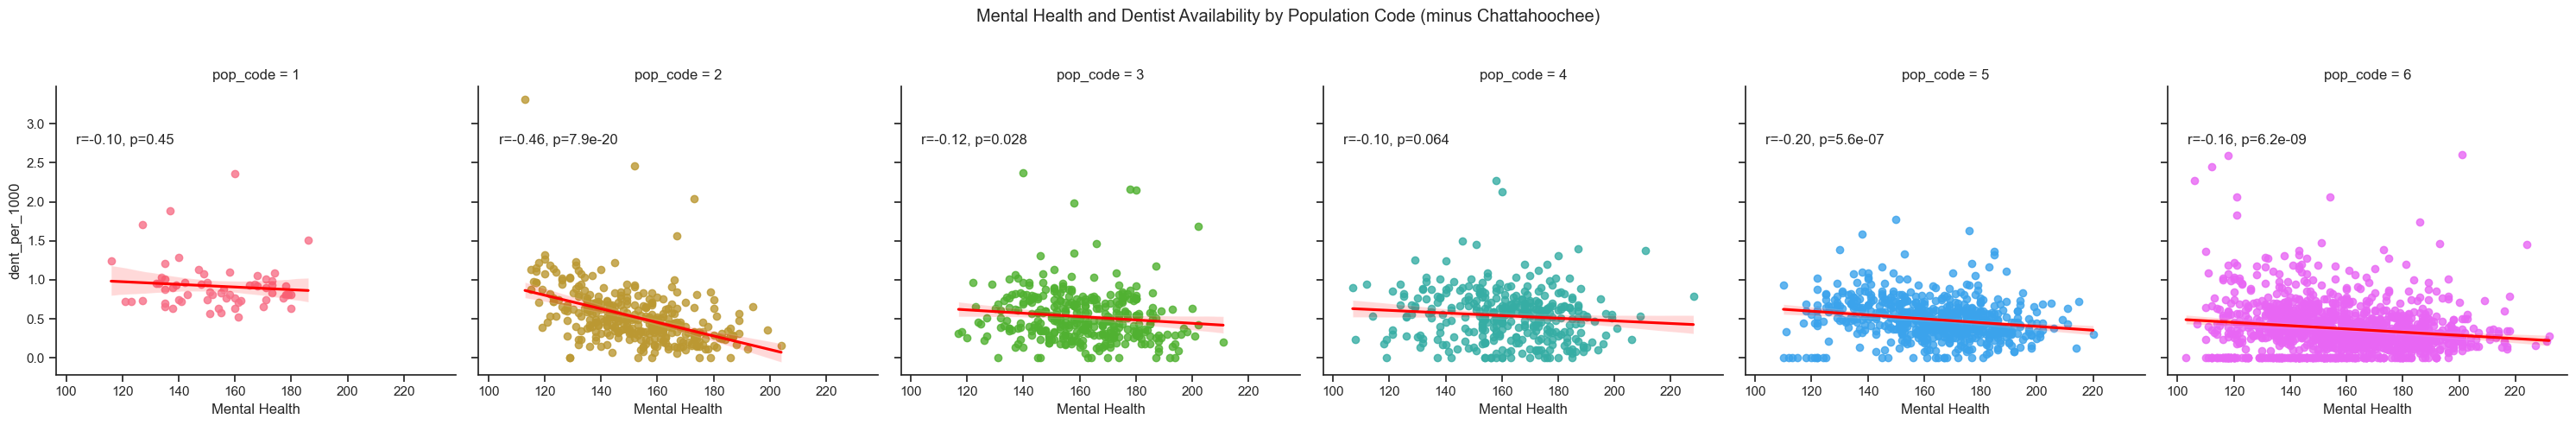

In [73]:

n=sns.lmplot(x = 'Mental Health', y = 'dent_per_1000',
           col = "pop_code",hue = "pop_code",palette = "husl",
           line_kws = {"color": "red"},data = dentpl_crude_pivot)



def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Mental Health'], data['dent_per_1000'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

    
n.map_dataframe(annotate)
n.fig.subplots_adjust(top = 0.8)
n.fig.suptitle("Mental Health and Dentist Availability by Population Code (minus Chattahoochee)")
plt.show()

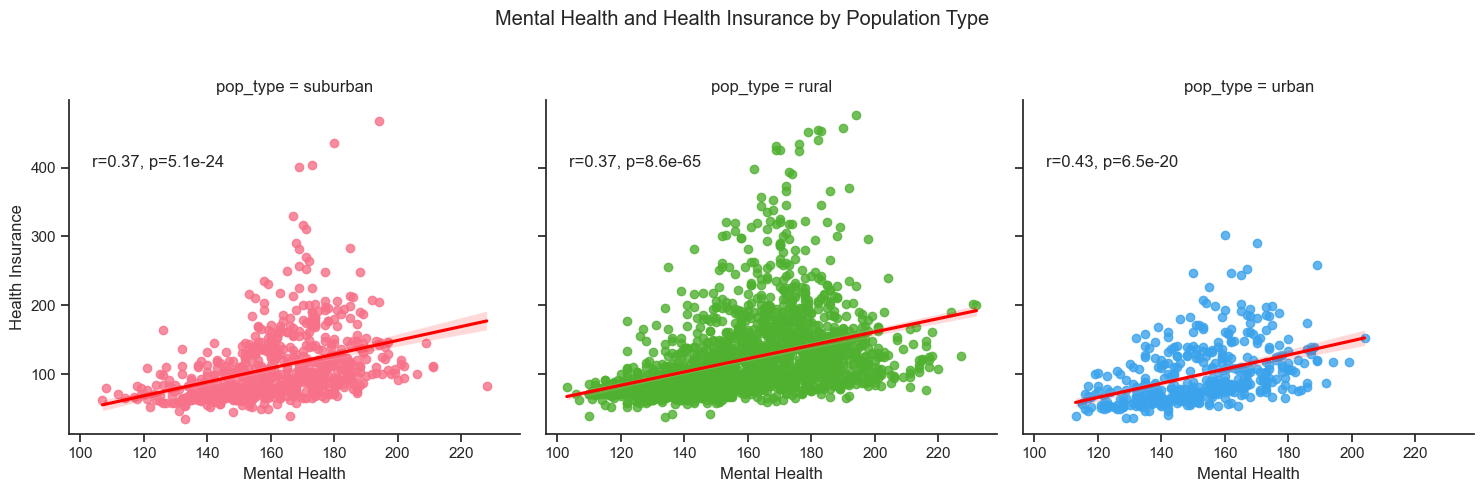

In [74]:
i=sns.lmplot(x = 'Mental Health', y = 'Health Insurance',
           col = "pop_type",hue = "pop_type",palette = "husl",
           line_kws = {"color": "red"},data = dentpl_crude_pivot)



def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Mental Health'], data['Health Insurance'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

    
i.map_dataframe(annotate)
i.fig.subplots_adjust(top = 0.8)
i.fig.suptitle("Mental Health and Health Insurance by Population Type")
plt.show()

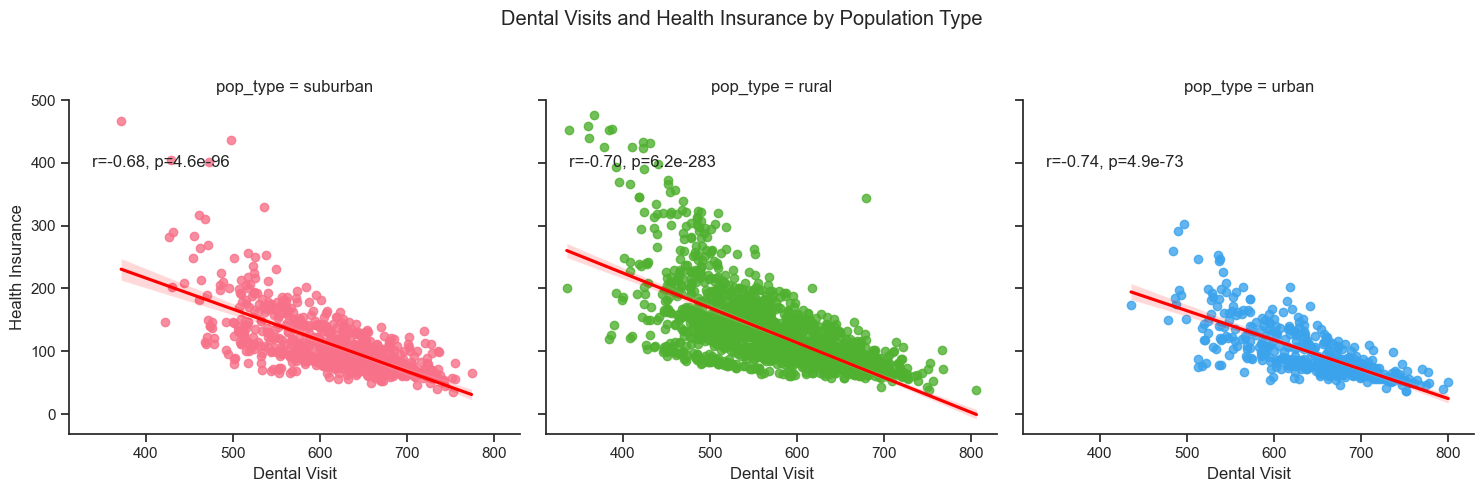

In [75]:
j=sns.lmplot(x = 'Dental Visit', y = 'Health Insurance',
           col = "pop_type",hue = "pop_type",palette = "husl",
           line_kws = {"color": "red"},data = dentpl_crude_pivot)



def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Dental Visit'], data['Health Insurance'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

    
j.map_dataframe(annotate)
j.fig.subplots_adjust(top = 0.8)
j.fig.suptitle("Dental Visits and Health Insurance by Population Type")
plt.show()

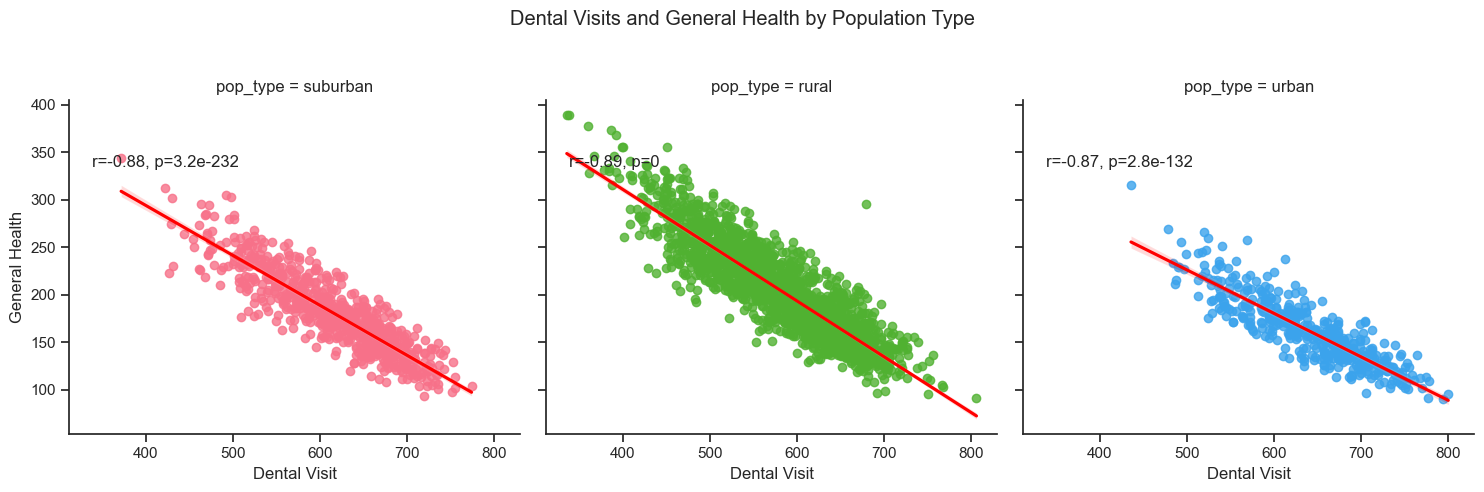

In [76]:
k=sns.lmplot(x = 'Dental Visit', y = 'General Health',
           col = "pop_type",hue = "pop_type",palette = "husl",
           line_kws = {"color": "red"},data = dentpl_crude_pivot)



def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Dental Visit'], data['General Health'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

    
k.map_dataframe(annotate)
k.fig.subplots_adjust(top = 0.8)
k.fig.suptitle("Dental Visits and General Health by Population Type")
plt.show()

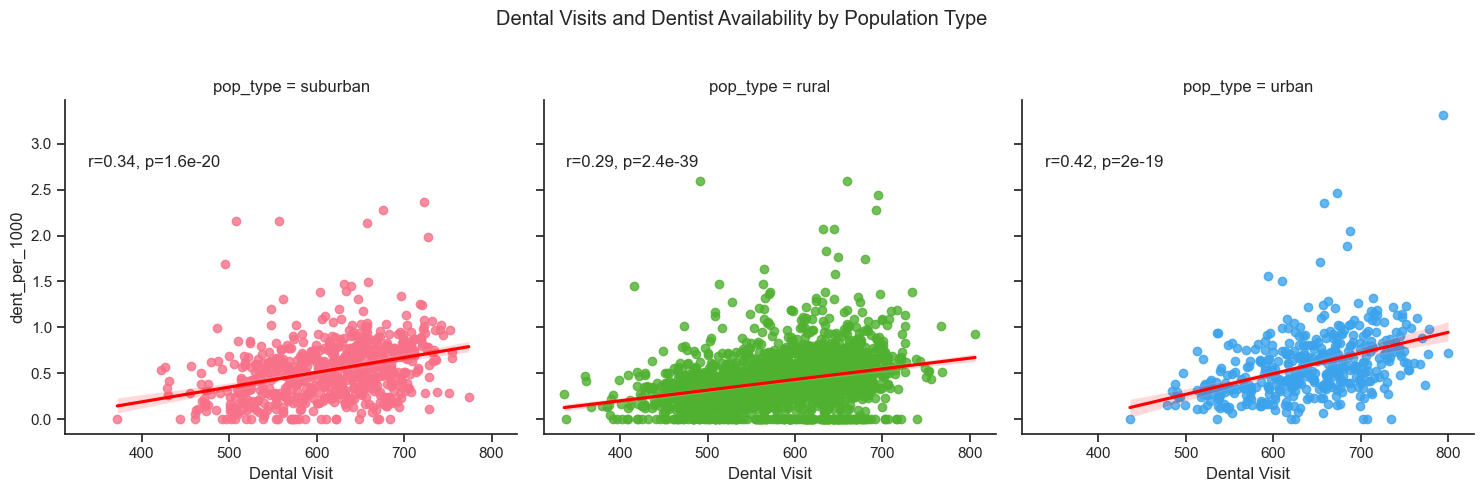

In [77]:
m=sns.lmplot(x = 'Dental Visit', y = 'dent_per_1000',
           col = "pop_type",hue = "pop_type",palette = "husl",
           line_kws = {"color": "red"},data = dentpl_crude_pivot)



def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Dental Visit'], data['dent_per_1000'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

    
m.map_dataframe(annotate)
m.fig.subplots_adjust(top = 0.8)
m.fig.suptitle("Dental Visits and Dentist Availability by Population Type")
plt.show()

In [115]:
stats.ttest_ind(dentpl_crude_pivot.dropna()['Mental Health'], dentpl_crude_pivot.dropna()['Dental Visit'])

TtestResult(statistic=-312.4333442420183, pvalue=0.0, df=6126.0)

In [116]:
stats.ttest_ind(dentpl_crude_pivot.dropna()['Mental Health'], dentpl_crude_pivot.dropna()['dent_per_1000'])

TtestResult(statistic=412.3640638087459, pvalue=0.0, df=6126.0)

In [80]:
#Looking at chi squared between Mental Health "grade" (bins set at std) and type of population distribution (urban, rural, etc)
bins=[100,128.8,154.6,180.4,206.2,233]
binspop=[0,2,4,6]
dentpl_crude_pivot['mental_health_grade']=pd.cut(dentpl_crude_pivot['Mental Health'],bins=bins, labels=['A','B','C','D','F'])
dentpl_crude_pivot['pop_new']=pd.cut(dentpl_crude_pivot['pop_code'],bins=binspop, labels=['urban','sub','rural'])


df_chi=pd.crosstab(dentpl_crude_pivot['pop_new'],dentpl_crude_pivot['mental_health_grade'])



d=chi2_contingency(df_chi)

stats, p_value, a, b=d

alpha=0.05
if p_value>alpha:
    print (f'p value as {p_value,10}, variables are independant (not related)')
else: print (f'p value as {p_value}, variables are dependant (related)')


#Looking at chi squared between Mental Health "grade" (bins set at std) and type of population distribution (urban, rural, etc)

p value as 7.521842754816242e-18, variables are dependant (related)


In [81]:
#Looking at chi squared between Dental Visits "grade" (bins set at std) and type of population distribution (urban, rural, etc)
bins2=[335,430,524,618,712,810]
dentpl_crude_pivot['dental_visit_grade']=pd.cut(dentpl_crude_pivot['Dental Visit'],bins=bins2, labels=['F','D','C','B','A'])


df_chi2=pd.crosstab(dentpl_crude_pivot['pop_new'],dentpl_crude_pivot['dental_visit_grade'])

from scipy.stats import chi2_contingency

d2=chi2_contingency(df_chi2)

stats, p_value, a, b=d2

alpha=0.05
if p_value>alpha:
    print (f'p value as {p_value,10}, variables are independant (not related)')
else: print (f'p value as {p_value}, variables are dependant (related)')

#Looking at chi squared between Dental Visits "grade" (bins set at std) and type of population distribution (urban, rural, etc)

p value as 4.647502399315961e-50, variables are dependant (related)


In [82]:
#Looking at chi squared between Dentists per 1000 "Level" (bins set at std) and Dental Visits (bins set around 157 deviation)bins3=[0,0.34,0.67,10]
bins3=[0,0.34,0.67,10]
dentpl_crude_pivot['dent_new']=pd.cut(dentpl_crude_pivot['dent_per_1000'],bins=bins3, labels=['few','some','many'])


df_chi3=pd.crosstab(dentpl_crude_pivot['dent_new'],dentpl_crude_pivot['dental_visit_grade'])

from scipy.stats import chi2_contingency

d3=chi2_contingency(df_chi3)

stats, p_value, a, b=d3

alpha=0.05
if p_value>alpha:
    print (f'p value as {p_value,10}, variables are independant (not related)')
else: print (f'p value as {p_value}, variables are dependant (related)')

#Looking at chi squared between Dentists per 1000 "Level" (bins set at std) and Dental Visits (bins set around 157 deviation)

p value as 3.4553511328270693e-97, variables are dependant (related)


In [83]:
#Looking at chi squared between Dentists per 1000 "Level" (bins set at std) and Mental Health "grade" (bins set at std)
df_chi4=pd.crosstab(dentpl_crude_pivot['dent_new'],dentpl_crude_pivot['mental_health_grade'])

from scipy.stats import chi2_contingency

d4=chi2_contingency(df_chi4)

stats, p_value, a, b=d4

alpha=0.05
if p_value>alpha:
    print (f'p value as {p_value,10}, variables are independant (not related)')
else: print (f'p value as {p_value}, variables are dependant (related)')

#Looking at chi squared between Dentists per 1000 "Level" (bins set at std) and Mental Health "grade" (bins set at std)

p value as 6.6761929330712e-48, variables are dependant (related)


In [84]:
dentpl_crude_pivot=dentpl_crude_pivot.drop(['dent_new'], axis=1)

In [85]:
dentna=dentpl_crude_pivot
dentna['pop_code'] = dentna['pop_code'].astype(str)

In [86]:
colorscale=['#1e90ff','#32cd32','#ffff76','#ffa500','#ff0000']
fig = ff.create_choropleth(fips=dentna['fips'], 
                           scope=['usa'],
                           values=dentna['mental_health_grade'],
                           county_outline={'color': 'rgb(0,0,0)', 'width': 0.3},
                           colorscale=colorscale,
                           title='Mental Health by County', 
                           legend_title='Mental Health Grade')

fig.layout.template = None
fig

C:\Users\smirn\anaconda3\Lib\site-packages\plotly\figure_factory\_county_choropleth.py:775: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.

C:\Users\smirn\anaconda3\Lib\site-packages\plotly\figure_factory\_county_choropleth.py:331: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.

C:\Users\smirn\anaconda3\Lib\site-packages\plotly\figure_factory\_county_choropleth.py:775: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.

C:\Users\smirn\anaconda3\Lib\site-packages\plotly\figure_factory\_county_choropleth.py:331: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.

C:\Users\smirn\anaconda3\Lib\site-packages\p

TypeError: 'MultiPolygon' object is not iterable

In [ ]:
fig6 = ff.create_choropleth(fips=dentna['fips'], 
                           scope=['usa'],
                           values=dentna['dental_visit_grade'],
                           county_outline={'color': 'rgb(0,0,0)', 'width': 0.3}, 
                            colorscale=colorscale,
                           title='Dental Visits by County', 
                           legend_title='Dental Visit Grade')

fig6.layout.template = None
fig6

In [ ]:
df_md = dentna[dentna['state'] == 'Maryland']
fig8 = ff.create_choropleth(fips=df_md['fips'], 
                           scope=['Maryland'],
                           values=df_md['mental_health_grade'],
                           county_outline={'color': 'rgb(0,0,0)', 'width': 0.80}, 
                            colorscale=colorscale,
                           title='Mental Health by County', 
                           legend_title='Mental Health Grade',
                            show_state_data=True,
                           show_hover=True)

fig8.layout.template = None
fig8

In [ ]:
fig7 = ff.create_choropleth(fips=df_md['fips'], 
                           scope=['Maryland'],
                           values=df_md['dental_visit_grade'],
                           county_outline={'color': 'rgb(0,0,0)', 'width': 0.8}, 
                            colorscale=colorscale,
                           title='Dental Visits by County', 
                           legend_title='Dental Visit Grade')

fig7.layout.template = None
fig7


In [87]:
bins8=[34,69,103,137,171,476]
dentna['health_insurance_grade']=pd.cut(dentna['Health Insurance'],bins=bins8, labels=['A','B','C','D','F'])
dentna.head()

index,fips,num_dentists,dent_per_1000,total_pop,pop_code,pop_type,lat,long,Geolocation,state,county,Annual Checkup,Dental Visit,General Health,Health Insurance,Mental Health,mental_health_grade,pop_new,dental_visit_grade,health_insurance_grade
0,01001,19.0,0.321516,59095.0,3,suburban,32.5322367,-86.6464395,-86.6464395 32.5322367,Alabama,Autauga,775.0,632.000000,184.000000,100.000000,171.000000,C,sub,B,B
1,01003,114.0,0.476401,239294.0,4,suburban,30.6592183,-87.7460666,-87.7460666 30.6592183,Alabama,Baldwin,759.0,663.000061,170.000000,88.999992,157.000000,C,sub,B,B
2,01005,8.0,0.320461,24964.0,6,rural,31.8702531,-85.4051035,-85.4051035 31.8702531,Alabama,Barbour,786.0,482.000000,291.000000,167.000015,192.999985,D,rural,D,D
3,01007,6.0,0.266940,22477.0,2,urban,33.0158929,-87.1271475,-87.1271475 33.0158929,Alabama,Bibb,741.0,537.000000,232.000015,140.000000,187.000000,D,urban,C,D
4,01009,10.0,0.169374,59041.0,2,urban,33.9773575,-86.56644,-86.56644 33.9773575,Alabama,Blount,752.0,590.000000,202.000000,125.000000,176.000000,C,urban,C,C


C:\Users\smirn\anaconda3\Lib\site-packages\plotly\express\_core.py:1958: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



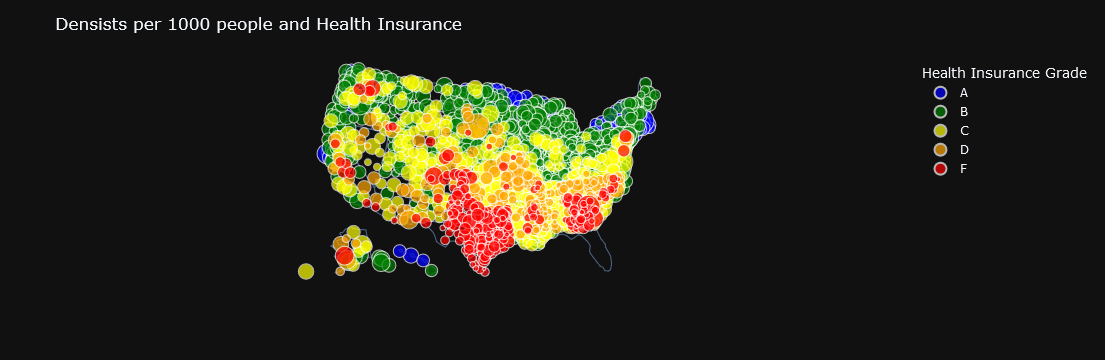

In [90]:

fig3 = px.scatter_geo(dentna,
                    lat=dentna['lat'],
                    lon=dentna['long'],
                    size="dent_per_1000",
                    category_orders={'health_insurance_grade':['A','B','C','D','F']},
                    color='health_insurance_grade',
                    color_discrete_sequence=["blue", "green", "yellow", "orange", "red"],
                    hover_name='county',
                     hover_data=["Mental Health", "Dental Visit", 'mental_health_grade','dental_visit_grade'])

fig3.update_layout(
        title = 'Densists per 1000 people and Health Insurance',
        geo_scope='usa',
        template="plotly_dark",
        legend_title="Health Insurance Grade"
    )

fig3